# Adult Income Dataset

In [1]:
# Importing the Required Libraries
import numpy as np
from pyspark.sql import SparkSession # Spark settings
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler # Data preprocessing    
from pyspark.ml.classification import LogisticRegression
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator    
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics 
from matplotlib import pyplot as plt
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import *
from IPython.core.display import display, HTML

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve
from subprocess import check_output
from pyspark.sql.functions import (count, col)
from pyspark.ml import Pipeline
from pyspark.ml.feature import (OneHotEncoderEstimator, 
                                StringIndexer, 
                                VectorAssembler)
from pyspark.ml.classification import (LogisticRegression, 
                                       DecisionTreeClassifier, 
                                       RandomForestClassifier)
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [2]:
# Todo: Set your own path.
CSV_PATH = "gs://example-bucket51/adult.data.csv" #for example, "gs://mis_big_bucket/assignment2/adult.data.csv"

In [3]:
def categoricalToNumeric(df, string_column):
    '''
    Convert categorical vars to numeric vars
    '''
    index_column = string_column + 'Index'
    vec_column = string_column + 'Vec' 
    
    indexer = StringIndexer(inputCol = string_column, outputCol = index_column)
    df = indexer.fit(df).transform(df)
    encoder = OneHotEncoderEstimator(inputCols = [index_column], outputCols = [vec_column])
    df = encoder.fit(df).transform(df)
    return df

In [4]:
def plotRoc(FPR, TPR):
    '''
    Plot ROC curve
    '''
    plt.figure(figsize=(6, 5))
    plt.plot([0, 1], [0, 1], 'r--')
    plt.title("Training ROC Curve")
    plt.plot(FPR, TPR)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.show()

In [5]:
def plotPr(recall, precision):
    '''
    Plot recall and precision
    '''
    plt.figure(figsize=(6, 5))
    plt.plot([0, 1], [1, 0], 'r--')
    plt.title("Training PR Curve")
    plt.plot(recall, precision)
    plt.xlabel('recall')
    plt.ylabel('precision')
    plt.show()

<b> Q2. a) Data Loading: read the csv file into a Dataframe. You could set ”inferschema” to  true  and  rename  the  columns  with  the  following  information:   ”age”,  ”workclass”,”fnlwgt”, ”education”, ”educationnum”, ”maritalstatus”, ”occupation”, ”relationship”,”race”, ”sex”, ”capitalgain”, ”capitalloss”, ”hoursperweek”, ”nativecountry”, ”income”.

In [6]:
    ##### Data loading
    '''
    Read the csv file and rename the columns
    '''
    sqlContext = SQLContext(sc)
    df = sqlContext.read.format("csv").options(
            header="true", inferschema="true").load(CSV_PATH)
    # header="true" if the first row is the name of variables.
    # header="false" if the first row is the data (no variable names).
    # inferSchema: automatically guess the data types for each field. 
    # If we set this option to TRUE, the API will read some sample records from the file to infer the schema.
    
    original_columns = df.columns
    updated_columns = ['age','workclass','fnlwgt','education','educationnum','maritalstatus', 
                       'occupation', 'relationship','race','sex','capitalgain','capitalloss',
                       'hoursperweek','nativecountry','income']
    
  
    print('Original DataFrame is ', df)
    print('')
    
    for i in range(len(original_columns)):
        df = df.withColumnRenamed(original_columns[i], updated_columns[i])

    print('Updated DataFrame is ', df)
    print('')

('Original DataFrame is ', DataFrame[39: int,  State-gov: string,  77516: double,  Bachelors: string,  13: double,  Never-married: string,  Adm-clerical: string,  Not-in-family: string,  White: string,  Male: string,  2174: double,  0: double,  40: double,  United-States: string,  <=50K: string])

('Updated DataFrame is ', DataFrame[age: int, workclass: string, fnlwgt: double, education: string, educationnum: double, maritalstatus: string, occupation: string, relationship: string, race: string, sex: string, capitalgain: double, capitalloss: double, hoursperweek: double, nativecountry: string, income: string])



<b> (b)Data preprocessing: Convert the categorical variables into numeric variables withML Pipelines and Feature Transformers. 

Display the column schema to identify columns with string type:

In [7]:
    ##### Data preprocessing
    print("Identify columns with string type:")    
    df.printSchema()

Identify columns with string type:
root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: double (nullable = true)
 |-- education: string (nullable = true)
 |-- educationnum: double (nullable = true)
 |-- maritalstatus: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capitalgain: double (nullable = true)
 |-- capitalloss: double (nullable = true)
 |-- hoursperweek: double (nullable = true)
 |-- nativecountry: string (nullable = true)
 |-- income: string (nullable = true)



Convert the categorical data to dense vector:

In [8]:
    ##### Data preprocessing
    category_columns = ["workclass", "education","maritalstatus","occupation","relationship","race","sex","nativecountry","income"]
    df_clean = df
    for each_column in category_columns:
        df_clean = categoricalToNumeric(df_clean, each_column)    
    print("Deal with categorical data and Convert the data to dense vector:")  
    df_clean.printSchema()

Deal with categorical data and Convert the data to dense vector:
root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: double (nullable = true)
 |-- education: string (nullable = true)
 |-- educationnum: double (nullable = true)
 |-- maritalstatus: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capitalgain: double (nullable = true)
 |-- capitalloss: double (nullable = true)
 |-- hoursperweek: double (nullable = true)
 |-- nativecountry: string (nullable = true)
 |-- income: string (nullable = true)
 |-- workclassIndex: double (nullable = false)
 |-- workclassVec: vector (nullable = true)
 |-- educationIndex: double (nullable = false)
 |-- educationVec: vector (nullable = true)
 |-- maritalstatusIndex: double (nullable = false)
 |-- maritalstatusVec: vector (nullable = true)
 |-- occupationIndex: double (null

In [9]:
    # Assemble the vectors
    input_col = ['age', 'fnlwgt', 'educationnum', 'capitalgain',
                 'capitalloss', 'hoursperweek','workclassIndex','educationIndex',
                 'maritalstatusIndex','occupationIndex','relationshipIndex','raceIndex',
                 'sexIndex','nativecountryIndex']
    assembler = VectorAssembler(inputCols = input_col, outputCol = 'features')
    df_clean = assembler.transform(df_clean)
    print("Deal with Categorical Label and Variables:")   
    df_clean.select(['features', 'incomeIndex']).show()

Deal with Categorical Label and Variables:
+--------------------+-----------+
|            features|incomeIndex|
+--------------------+-----------+
|(14,[0,1,2,5,6,7,...|        0.0|
|(14,[0,1,2,5,8,9,...|        0.0|
|(14,[0,1,2,5,7,9,...|        0.0|
|[28.0,338409.0,13...|        0.0|
|(14,[0,1,2,5,7,9,...|        0.0|
|[49.0,160187.0,5....|        0.0|
|(14,[0,1,2,5,6,9]...|        1.0|
|[31.0,45781.0,14....|        1.0|
|(14,[0,1,2,3,5,7,...|        1.0|
|(14,[0,1,2,5,7,9,...|        1.0|
|(14,[0,1,2,5,6,7,...|        1.0|
|[23.0,122272.0,13...|        0.0|
|[32.0,205019.0,12...|        0.0|
|(14,[0,1,2,5,7,9,...|        1.0|
|(14,[0,1,2,5,7,9,...|        0.0|
|(14,[0,1,2,5,6,8,...|        0.0|
|(14,[0,1,2,5,8,9,...|        0.0|
|(14,[0,1,2,5,7,9]...|        0.0|
|[43.0,292175.0,14...|        1.0|
|(14,[0,1,2,5,7],[...|        1.0|
+--------------------+-----------+
only showing top 20 rows



Split the data into training set and test set with ratio of 70% and 30% and set the seed to 100.

In [10]:
    # Split data into training set and test set
    data_set = df_clean.select(['features', 'incomeIndex'])
    train_set, test_set = data_set.randomSplit([0.7, 0.3], 100)
    
    train_set.show(5,False)
    test_set.show(5,False)

+-------------------------------------------------+-----------+
|features                                         |incomeIndex|
+-------------------------------------------------+-----------+
|(14,[0,1,2,3,5],[31.0,132996.0,9.0,5178.0,45.0]) |1.0        |
|(14,[0,1,2,3,5],[31.0,187560.0,9.0,15024.0,40.0])|1.0        |
|(14,[0,1,2,3,5],[41.0,163287.0,9.0,7688.0,43.0]) |1.0        |
|(14,[0,1,2,3,5],[42.0,154076.0,9.0,7688.0,50.0]) |1.0        |
|(14,[0,1,2,3,5],[48.0,83444.0,9.0,7298.0,40.0])  |1.0        |
+-------------------------------------------------+-----------+
only showing top 5 rows

+-------------------------------------------------------------+-----------+
|features                                                     |incomeIndex|
+-------------------------------------------------------------+-----------+
|(14,[0,1,2,3,5],[47.0,185385.0,9.0,5013.0,24.0])             |0.0        |
|(14,[0,1,2,3,5],[52.0,102828.0,9.0,7688.0,40.0])             |1.0        |
|(14,[0,1,2,3,5],[6

<b>(c) Modelling: Train a logistic regression model from Spark MLlib with train set. After training, plot ROC curve.

Training:
training_summary.roc.show():
+--------------------+-------------------+
|                 FPR|                TPR|
+--------------------+-------------------+
|                 0.0|                0.0|
|2.886836027713626E-4|0.05002718868950517|
|4.618937644341801...|0.09062896501721951|
|0.001616628175519...| 0.1281493565343484|
|0.003002309468822171| 0.1649447163313395|
|0.005138568129330...| 0.1993837230378829|
| 0.00825635103926097|0.23074134493384085|
|0.011316397228637413|0.26228022475983326|
|0.015300230946882216| 0.2909189777052746|
|0.019572748267898385|0.31865144100054377|
| 0.02407621247113164| 0.3456588725756752|
|0.028752886836027714| 0.3721225303607033|
| 0.03348729792147806|0.39840493021569695|
| 0.03810623556581986|0.42504984593075945|
| 0.04336027713625866| 0.4497009244154432|
| 0.04948036951501155| 0.4716331339496103|
| 0.05508083140877598|0.49519666485408737|
|0.061605080831408775| 0.5158600688780134|
| 0.06732101616628175| 0.5390610839224216|
| 0.07384526558

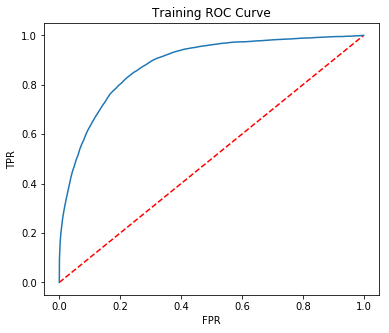

In [11]:
    ##### Modeling
    # Run logistic regression
    lr = LogisticRegression(featuresCol = 'features', labelCol = 'incomeIndex').fit(train_set)
    training_summary = lr.summary
        
    print("Training:")
    # Plot ROC Curve
    print("training_summary.roc.show():")
    training_summary.roc.show()
    print("Plot Training ROC Curve:")
    training_FPR = training_summary.roc.select('FPR').collect()
    training_TPR = training_summary.roc.select('TPR').collect()
    plotRoc(training_FPR, training_TPR)  

Plot Precision-Recall curve of the training process

training_summary.pr.show():
+-------------------+------------------+
|             recall|         precision|
+-------------------+------------------+
|                0.0|0.9822064056939501|
|0.05002718868950517|0.9822064056939501|
|0.09062896501721951| 0.984251968503937|
| 0.1281493565343484|0.9619047619047619|
| 0.1649447163313395|0.9459459459459459|
| 0.1993837230378829|0.9251471825063078|
|0.23074134493384085|0.8990112994350282|
|0.26228022475983326|0.8807060255629945|
| 0.2909189777052746|0.8582887700534759|
|0.31865144100054377|0.8383404864091559|
| 0.3456588725756752|0.8205679862306369|
| 0.3721225303607033|0.8047824382595061|
|0.39840493021569695|0.7912167026637869|
|0.42504984593075945|0.7803660565723793|
| 0.4497009244154432|0.7676361386138614|
| 0.4716331339496103| 0.752240531945649|
|0.49519666485408737|0.7411828540423223|
| 0.5158600688780134|0.7273191924354715|
| 0.5390610839224216|0.7183574879227053|
| 0.5597244879463477|0.7071215937714679|
+-------------------+--------

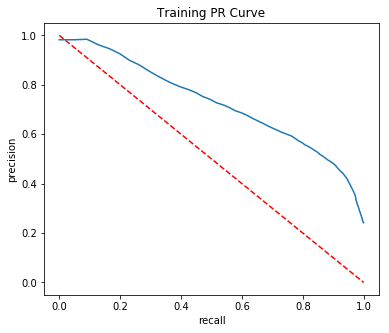

In [12]:
    # Plot Precision-Recall Curve
    print("training_summary.pr.show():")
    training_summary.pr.show()
    print("Plot Training Precision-Recall Curve:")
    training_recall = training_summary.pr.select('recall').collect()
    training_precision = training_summary.pr.select('precision').collect()
    plotPr(training_recall, training_precision)

<b>(d) Evaluation: Apply the trained model on the test set.  Provide the value of area under ROC, accuracy, and confusion matrix. 

In [13]:
    ##### Evaluation    
    print(" ")
    print("Evaluation:")
    test_summary = lr.evaluate(test_set)
    # Area under ROC curve
    print("Test Area under ROC is {}".format(test_summary.areaUnderROC))
    # Accuracy
    print("Test Accuracy is {}".format(test_summary.accuracy))
    # Confusion Matrix
    test_prediction = lr.transform(test_set)
    predictionAndLabels = test_prediction.select('prediction', 'incomeIndex').rdd
    metrics = MulticlassMetrics(predictionAndLabels)
    print("Confusion Matrix is", metrics.confusionMatrix().toArray())
    print("Done!")

 
Evaluation:
Test Area under ROC is 0.885686830499
Test Accuracy is 0.841098426412
('Confusion Matrix is', array([[6955.,  444.],
       [1101., 1223.]]))
Done!


In [14]:
type(df)

pyspark.sql.dataframe.DataFrame

In [15]:
data = df
data.show()

+---+-----------------+--------+-------------+------------+--------------------+------------------+--------------+-------------------+-------+-----------+-----------+------------+--------------+------+
|age|        workclass|  fnlwgt|    education|educationnum|       maritalstatus|        occupation|  relationship|               race|    sex|capitalgain|capitalloss|hoursperweek| nativecountry|income|
+---+-----------------+--------+-------------+------------+--------------------+------------------+--------------+-------------------+-------+-----------+-----------+------------+--------------+------+
| 50| Self-emp-not-inc| 83311.0|    Bachelors|        13.0|  Married-civ-spouse|   Exec-managerial|       Husband|              White|   Male|        0.0|        0.0|        13.0| United-States| <=50K|
| 38|          Private|215646.0|      HS-grad|         9.0|            Divorced| Handlers-cleaners| Not-in-family|              White|   Male|        0.0|        0.0|        40.0| United-State

In [16]:
data.summary().show(1)

+-------+-----+---------+------+---------+------------+-------------+----------+------------+-----+-----+-----------+-----------+------------+-------------+------+
|summary|  age|workclass|fnlwgt|education|educationnum|maritalstatus|occupation|relationship| race|  sex|capitalgain|capitalloss|hoursperweek|nativecountry|income|
+-------+-----+---------+------+---------+------------+-------------+----------+------------+-----+-----+-----------+-----------+------------+-------------+------+
|  count|32560|    32560| 32560|    32560|       32560|        32560|     32560|       32560|32560|32560|      32560|      32560|       32560|        32560| 32560|
+-------+-----+---------+------+---------+------------+-------------+----------+------------+-----+-----+-----------+-----------+------------+-------------+------+
only showing top 1 row



In [17]:
data.describe()

DataFrame[summary: string, age: string, workclass: string, fnlwgt: string, education: string, educationnum: string, maritalstatus: string, occupation: string, relationship: string, race: string, sex: string, capitalgain: string, capitalloss: string, hoursperweek: string, nativecountry: string, income: string]

In [18]:
data.toPandas().head(10).transpose()

,0,1,2,3,4,5,6,7,8,9
age,50,38,53,28,37,49,52,31,42,37
workclass,Self-emp-not-inc,Private,Private,Private,Private,Private,Self-emp-not-inc,Private,Private,Private
fnlwgt,83311,215646,234721,338409,284582,160187,209642,45781,159449,280464
education,Bachelors,HS-grad,11th,Bachelors,Masters,9th,HS-grad,Masters,Bachelors,Some-college
educationnum,13,9,7,13,14,5,9,14,13,10
maritalstatus,Married-civ-spouse,Divorced,Married-civ-spouse,Married-civ-spouse,Married-civ-spouse,Married-spouse-absent,Married-civ-spouse,Never-married,Married-civ-spouse,Married-civ-spouse
occupation,Exec-managerial,Handlers-cleaners,Handlers-cleaners,Prof-specialty,Exec-managerial,Other-service,Exec-managerial,Prof-specialty,Exec-managerial,Exec-managerial
relationship,Husband,Not-in-family,Husband,Wife,Wife,Not-in-family,Husband,Not-in-family,Husband,Husband
race,White,White,Black,Black,White,Black,White,White,White,Black
sex,Male,Male,Male,Female,Female,Female,Male,Female,Male,Male


In [19]:
data.printSchema()

root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: double (nullable = true)
 |-- education: string (nullable = true)
 |-- educationnum: double (nullable = true)
 |-- maritalstatus: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capitalgain: double (nullable = true)
 |-- capitalloss: double (nullable = true)
 |-- hoursperweek: double (nullable = true)
 |-- nativecountry: string (nullable = true)
 |-- income: string (nullable = true)



<b>Count of records

In [20]:
data.count()

32560

<b>Display the columns in the dataset

In [21]:
data.columns

['age',
 'workclass',
 'fnlwgt',
 'education',
 'educationnum',
 'maritalstatus',
 'occupation',
 'relationship',
 'race',
 'sex',
 'capitalgain',
 'capitalloss',
 'hoursperweek',
 'nativecountry',
 'income']

In [22]:
data.crosstab('age', 'income').sort("age_income").show()

+----------+------+-----+
|age_income| <=50K| >50K|
+----------+------+-----+
|        17|   395|    0|
|        18|   550|    0|
|        19|   710|    2|
|        20|   753|    0|
|        21|   717|    3|
|        22|   752|   13|
|        23|   865|   12|
|        24|   767|   31|
|        25|   788|   53|
|        26|   722|   63|
|        27|   754|   81|
|        28|   748|  119|
|        29|   679|  134|
|        30|   690|  171|
|        31|   705|  183|
|        32|   639|  189|
|        33|   684|  191|
|        34|   643|  243|
|        35|   659|  217|
|        36|   635|  263|
+----------+------+-----+
only showing top 20 rows



In [23]:
# numerical variabels
num_vars = ["age", "fnlwgt", "educationnum", "capitalgain", "capitalloss", "hoursperweek"]
# categorical variables
cat_vars = ["workclass", "education", "maritalstatus", "occupation", 
            "relationship", "race", "sex", "nativecountry"]

<b>Count null values in columns

In [25]:
# count null values in columns
def countNull(data, var):
    return data.where(data[var].isNull()).count()

all_cols = num_vars + cat_vars
{var: countNull(data, var) for var in all_cols}

{'age': 0,
 'capitalgain': 0,
 'capitalloss': 0,
 'education': 0,
 'educationnum': 0,
 'fnlwgt': 0,
 'hoursperweek': 0,
 'maritalstatus': 0,
 'nativecountry': 0,
 'occupation': 0,
 'race': 0,
 'relationship': 0,
 'sex': 0,
 'workclass': 0}

In [26]:
# featurize categorical columns
stages = []
for cat_var in cat_vars:
    # Category Indexing with StringIndexer
    stringIndexer = StringIndexer(
        inputCol=cat_var, 
        outputCol=cat_var+"_indx")
    # Use OneHotEncoder to convert categorical variables into binary SparseVectors
    encoder = OneHotEncoderEstimator(
        inputCols=[stringIndexer.getOutputCol()], 
        outputCols=[cat_var + "_vec"])
    # Add stages.  These are not run here, but will run all at once later on.
    stages += [stringIndexer, encoder]

In [27]:
# Convert label into label indices using the StringIndexer
label_indx = StringIndexer(
    inputCol="income", 
    outputCol="label")
stages += [label_indx]

In [28]:
assembler_inputs = [c+"_vec" for c in cat_vars] + num_vars
assembler = VectorAssembler(
    inputCols=assembler_inputs, 
    outputCol="features")
stages += [assembler]

In [29]:
# Create a Pipeline.
pipeline = Pipeline(stages=stages)

# Run the feature transformations.
#  - fit() computes feature statistics as needed.
#  - transform() actually transforms the features.
data = pipeline.fit(data).transform(data)
# Keep relevant columns for later evaluation
selectedcols = ["label", "features"] + all_cols
data = data.select(selectedcols)
data.toPandas().head(15)

,label,features,age,fnlwgt,educationnum,capitalgain,capitalloss,hoursperweek,workclass,education,maritalstatus,occupation,relationship,race,sex,nativecountry
0,0.0,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",50,83311.0,13.0,0.0,0.0,13.0,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States
1,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",38,215646.0,9.0,0.0,0.0,40.0,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States
2,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",53,234721.0,7.0,0.0,0.0,40.0,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States
3,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",28,338409.0,13.0,0.0,0.0,40.0,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba
4,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",37,284582.0,14.0,0.0,0.0,40.0,Private,Masters,Married-civ-spouse,Exec-managerial,Wife,White,Female,United-States
5,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",49,160187.0,5.0,0.0,0.0,16.0,Private,9th,Married-spouse-absent,Other-service,Not-in-family,Black,Female,Jamaica
6,1.0,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",52,209642.0,9.0,0.0,0.0,45.0,Self-emp-not-inc,HS-grad,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States
7,1.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",31,45781.0,14.0,14084.0,0.0,50.0,Private,Masters,Never-married,Prof-specialty,Not-in-family,White,Female,United-States
8,1.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",42,159449.0,13.0,5178.0,0.0,40.0,Private,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States
9,1.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",37,280464.0,10.0,0.0,0.0,80.0,Private,Some-college,Married-civ-spouse,Exec-managerial,Husband,Black,Male,United-States


<b>Split the data into training set and test set with ratio of 80% and 20%.

In [30]:
(train, test) = data.randomSplit([0.8, 0.2], seed=777)
print(train.count())
print(test.count())

26067
6493


In [31]:
# 1. Logistic regression model
logr = LogisticRegression(
    maxIter = 10,
    regParam = 0.05,
    labelCol="label",
    featuresCol="features"
)

# 2. decision tree model
d_tree = DecisionTreeClassifier(
    maxDepth = 10,
    labelCol = "label",
    featuresCol="features"
)

# 3. random forest model
r_forest = RandomForestClassifier(
    numTrees = 10,
    labelCol = "label",
    featuresCol="features"
)

# fit models
lr_model = logr.fit(train)
dt_model = d_tree.fit(train)
rf_model = r_forest.fit(train)

<b>Provide the value of accuracy

In [33]:
# model evaluator
def testModel(model, data):
    pred = model.transform(data)
    evaluator = BinaryClassificationEvaluator(labelCol="label")
    return evaluator.evaluate(pred)

# accuracy output
models = {
    "Logistic regression": lr_model,
    "Decision tree": dt_model,
    "Random forest": rf_model
}

# model performance comparisson
{model_name: testModel(model, test) for model_name,model in models.items()}

{'Decision tree': 0.7547809465589691,
 'Logistic regression': 0.9019659799848027,
 'Random forest': 0.8881611284297526}